In [1]:
# scientific libraries
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from skimage import io

# general libraries
import os  
import json
import time
import h5py as h5

# local libraries
from analysis import *
from general_utils import *
from hdf_utils import unpack_hdf
from scalebars import *

import balance_configs as configs
import experiments as exps
import analysis as ana

In [2]:
# %matplotlib notebook
%matplotlib widget
plt.rcParams.update({"figure.max_open_warning": 0})

In [3]:
base_path = "/mnt/Data/NEURONoutput/sac_net/"

In [4]:
model_path = os.path.join(base_path, "vc_runs/")
save_name = "test"
# load_name = None
load_name = "test"

model_config = configs.sac_mode_config(vc_mode=True)

if load_name is None:
    from ei_balance_nogui import *
    os.makedirs(model_path, exist_ok=True)
    save_path = os.path.join(model_path, save_name) + ".h5"
    load_name = save_name
    exps.sacnet_run(
        save_path,
        model_config,
        n_nets=3,
        n_trials=3,
        rho_steps=[0.0, 1.0],
        pool_sz=8,
        vc_mode=True,
    )

t0 = time.time()
with h5.File(os.path.join(model_path, load_name) + ".h5", "r") as pckg:
    d = unpack_hdf(pckg)
print("data unpacked in %.1fs" % (time.time() - t0))
    
# deserialize parameter dicts
for i in d.keys():
    for rho in d[i].keys():
        d[i][rho]["params"] = json.loads(d[i][rho]["params"])
        
# rearrange hierarchy (rho condition above repeats)
rhos = list(d.keys())
idxs = list(d[rhos[0]].keys())

data unpacked in 0.0s


In [5]:
transmitters = list(d[0.0][0]["soma"].keys())
params = d[0.0][0]["params"]
dir_labels = params["dir_labels"]
xaxis = np.arange(int(params["tstop"] / params["dt"]) + 1) * params["dt"]

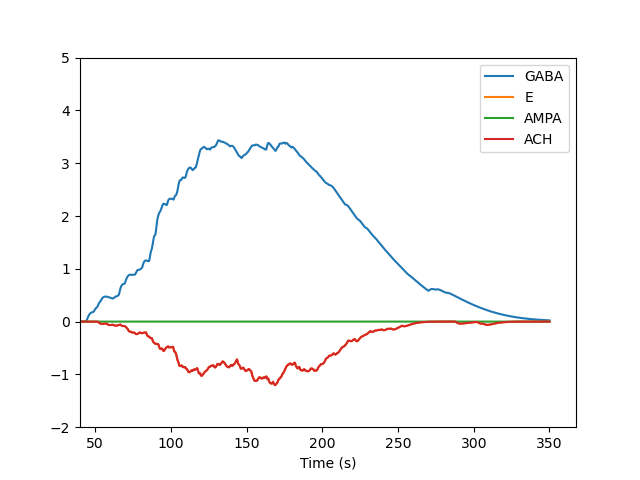

In [6]:
rho = 0.0
net = 0

ex_fig, ex_ax = plt.subplots(1)
for k, v in d[rho][net]["soma"].items():
    ex_ax.plot(xaxis, v[0, 0], label=k)

ex_ax.set_xlabel("Time (s)")
ex_ax.set_xlim(40)
ex_ax.set_ylim(-2, 5)
ex_ax.legend()

In [7]:
vc_trial_avgs = {
    rho: {
        n: {trans: np.mean(rec, axis=0) for trans, rec in net["soma"].items()}
        for n, net in nets.items()
    }
    for rho, nets in d.items()      
}
    
vc_net_avgs = {
    rho: {
        trans: np.mean([net[trans] for net in nets.values()], axis=0)
        for trans in transmitters
    }
    for rho, nets in vc_trial_avgs.items()
}

(10.0, 300.0)

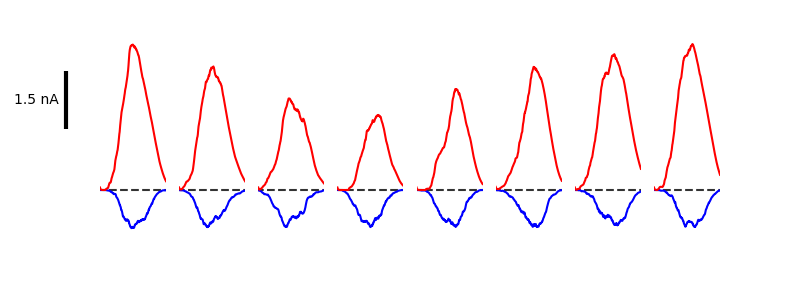

In [12]:
net_avg_fig, net_avg_ax = plt.subplots(
    1, len(dir_labels), sharex=True, sharey="row", figsize=(8, 3))

for i, ax in enumerate(net_avg_ax):
    ax.plot([xaxis[0], xaxis[-1]], [0., 0.], c="black", linestyle="--", alpha=0.8)
    ax.plot(xaxis, vc_net_avgs[1.0]["E"][i], c="blue")
    ax.plot(xaxis, vc_net_avgs[1.0]["GABA"][i], c="red")

clean_axes(net_avg_ax, remove_spines=["left", "right", "top", "bottom"])

add_scalebar(
    net_avg_ax[0], 
    matchx=False, 
    matchy=False, 
    sizey=1.5, 
    labely="1.5 nA",
    sep=5,
    barwidth=3,
    loc="center",
    bbox_to_anchor=(40, 200),
)

net_avg_ax[-1].set_ylim(-2, 4)
net_avg_ax[-1].set_xlim(10, 300)

In [9]:
upward_e_avgs = vc_net_avgs[1.00]["E"] * -1
time_offsets = np.array([
    find_rise_bsln(d, bsln_start=0, bsln_end=1, offset=0.03, step=1)
    for d in upward_e_avgs
]) * params["dt"]
align_offsets = np.max(time_offsets) - time_offsets

print("E field offsets (ms):", time_offsets)
print("alignment_shifts (ms):", align_offsets)

E field offsets (ms): [55.  38.8 21.  40.1 53.2 45.2 45.3 58.4]
alignment_shifts (ms): [ 3.4 19.6 37.4 18.3  5.2 13.2 13.1  0. ]


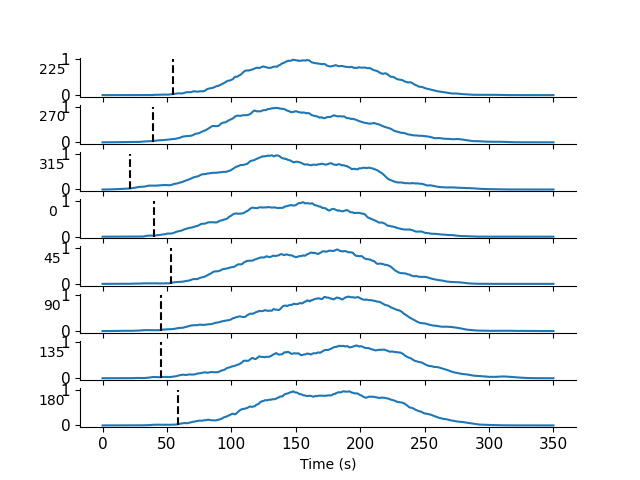

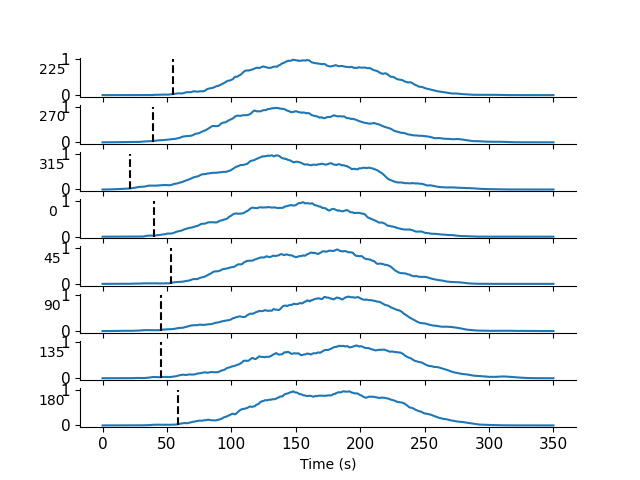

In [10]:
rf_offset_fig, rf_offset_ax = plt.subplots(8)
for ax, dr, avg, off in zip(rf_offset_ax, dir_labels, upward_e_avgs, time_offsets):
    ax.plot(xaxis, avg)
    ax.plot([off, off], [0, 1], linestyle="--", c="black")
    ax.set_ylabel(dr, rotation="horizontal", labelpad=6., position=(1, 0.3))
    
clean_axes(rf_offset_ax)
rf_offset_ax[-1].set_xlabel("Time (s)")
rf_offset_fig.show()

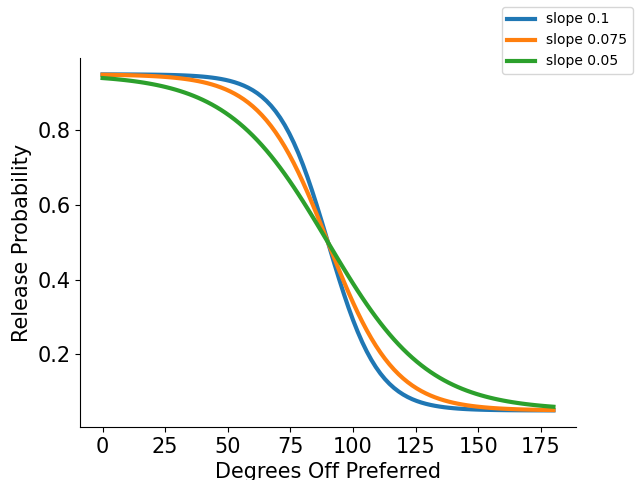

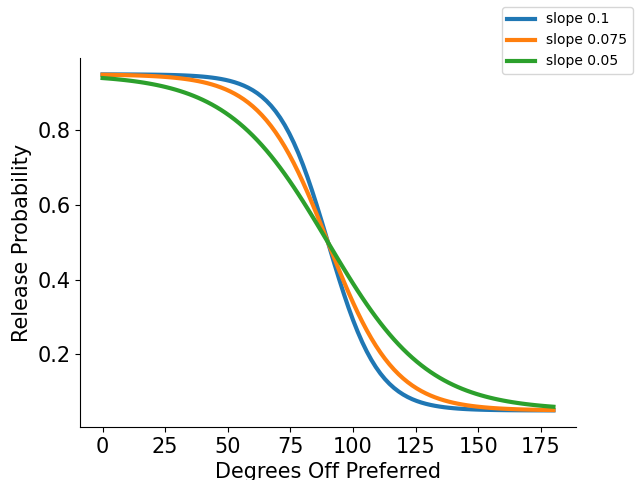

In [11]:
def sigmoid (d, n, p, offset=90, slope=0.075): 
    return p + (n - p) * (1 - 1 / (1 + np.exp((d - offset) * slope)))

dir_range = np.linspace(0, 180, 100) 
prob_p1 = np.squeeze(sigmoid(dir_range, 0.05, 0.95, slope=0.1))
prob_p075 = np.squeeze(sigmoid(dir_range, 0.05, 0.95))
prob_p05 = np.squeeze(sigmoid(dir_range, 0.05, 0.95, slope=0.05))

sigmoid_fig, sigmoid_ax = plt.subplots(1)
sigmoid_ax.plot(dir_range, prob_p1, linewidth=3, label="slope 0.1")
sigmoid_ax.plot(dir_range, prob_p075, linewidth=3, label="slope 0.075")
sigmoid_ax.plot(dir_range, prob_p05, linewidth=3, label="slope 0.05")
sigmoid_ax.set_ylabel("Release Probability", fontsize=15)
sigmoid_ax.set_xlabel("Degrees Off Preferred", fontsize=15)
clean_axes(sigmoid_ax, ticksize=15)
# sigmoid_fig.savefig(os.path.join(data_path, "prob_sigmoid.svg"), bbox_inches="tight")
sigmoid_fig.legend()
sigmoid_fig.show()